![title](https://media.giphy.com/media/xT0BKi1TLjmKiu1HGg/giphy.gif)

In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from itertools import chain
import cv2
import torch
from tqdm import tqdm_notebook
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.optim import lr_scheduler
from IPython.display import clear_output

In [2]:
model = models.mobilenet_v2(True)

In [3]:
DATA_ROOT = '/data/kaggle-iWildCam-2019/'
IMG_SIZE = 224
BATCH_SIZE = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 14
NUM_STEPS = 157039/BATCH_SIZE
NUM_VAL_STEPS = 39260/BATCH_SIZE

In [42]:
# utils

def plot_history(train_history, val_history, epoch, title='loss'):
    plt.figure()
    plt.title(f'{title} [{epoch}]')
    plt.plot(train_history, label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='pink', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, os.path.join(DATA_ROOT,filename))

    
def f1_score(y_true, y_pred):
    eps = 1e-9
    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)
    
    TP = np.array([])
    FP = np.array([])
    FN = np.array([])
    for c in y_true.unique():
        mask = y_true==c
        TP = np.append(TP, np.array(torch.sum(y_pred[mask]==c)) + eps)
        FN = np.append(FN, np.array(torch.sum(y_pred[mask]!=c)))
        FP = np.append(FP, np.array(torch.sum(y_pred[~mask]==c)))
    Macro_Precision = np.mean(TP / (TP + FP))
    Macro_Recall = np.mean(TP / (TP + FN))
    Macro_F_score = 2. * (Macro_Precision * Macro_Recall) / (Macro_Precision + Macro_Recall)
    
    return Macro_F_score

In [6]:
train_df_all = pd.read_csv(DATA_ROOT + 'train.csv')
train_df = train_df_all[['category_id', 'file_name']]
print(train_df.shape[0])
train_df.head()

196299


,category_id,file_name
0,19,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg
1,19,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg
2,0,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg
3,0,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg
4,0,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg


## A little EDA

In [7]:
# code from https://www.kaggle.com/gpreda/iwildcam-2019-eda

classes_wild = {0: 'empty', 1: 'deer', 2: 'moose', 3: 'squirrel', 4: 'rodent', 5: 'small_mammal', \
                6: 'elk', 7: 'pronghorn_antelope', 8: 'rabbit', 9: 'bighorn_sheep', 10: 'fox', 11: 'coyote', \
                12: 'black_bear', 13: 'raccoon', 14: 'skunk', 15: 'wolf', 16: 'bobcat', 17: 'cat',\
                18: 'dog', 19: 'opossum', 20: 'bison', 21: 'mountain_goat', 22: 'mountain_lion'}

train_df['classes_wild'] = train_df['category_id'].apply(lambda cw: classes_wild[cw])
# Category distribution
train_df['classes_wild'].value_counts()

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


empty            131457
opossum           14106
raccoon            8623
coyote             7209
rabbit             6938
deer               6102
bobcat             5975
cat                4759
squirrel           3398
dog                3035
rodent             2210
skunk              1361
fox                1093
mountain_lion        33
Name: classes_wild, dtype: int64

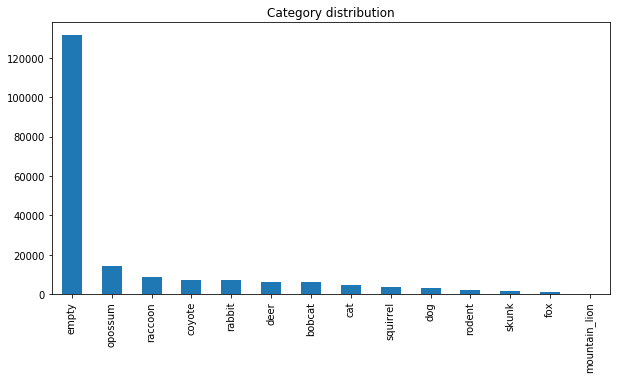

In [8]:
plt.figure(figsize=(10,5))
train_df['classes_wild'].value_counts().plot(kind='bar',  title="Category distribution")
plt.show()

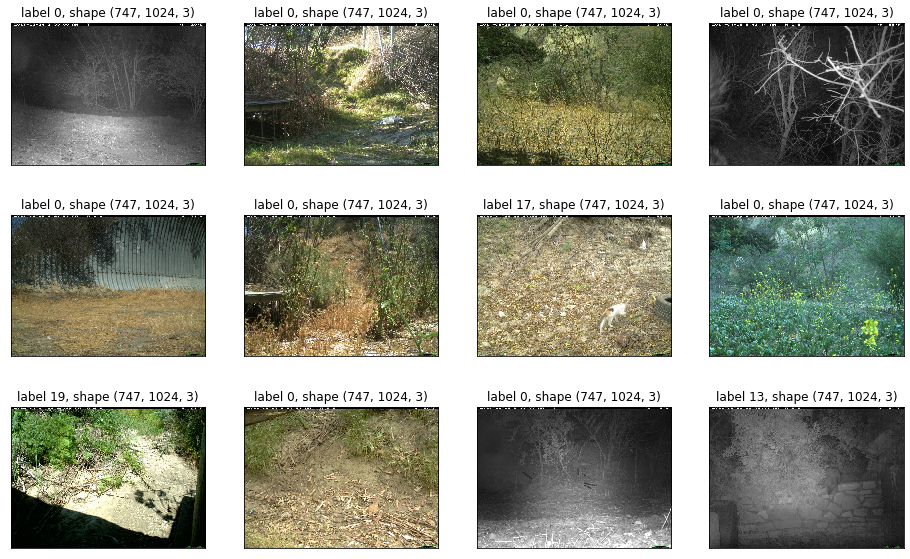

In [9]:
fig = plt.figure(figsize=(16,10))
for idx, image in enumerate(np.random.choice(train_df['file_name'].values, 12)):
    ax = fig.add_subplot(3, 4, idx+1, xticks=[], yticks=[])
    img = cv2.imread(DATA_ROOT+'train_images/'+image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    labl = train_df.loc[train_df['file_name']==image, 'category_id'].values[0]
    ax.set_title('label {}, shape {}'.format(labl, img.shape))

In [10]:
NUM_CLASSES = train_df['category_id'].nunique()
CLASSES_TO_USE = train_df['category_id'].unique()
CLASSES_TO_USE

array([19,  0,  3,  8,  4, 13,  1, 11, 16, 17, 14, 18, 10, 22])

In [11]:
CLASSMAP = dict(
    [(i, j) for i, j
     in zip(CLASSES_TO_USE, range(NUM_CLASSES))
    ]
)

REVERSE_CLASSMAP = dict([(v, k) for k, v in CLASSMAP.items()])

CLASSMAP

{19: 0,
 0: 1,
 3: 2,
 8: 3,
 4: 4,
 13: 5,
 1: 6,
 11: 7,
 16: 8,
 17: 9,
 14: 10,
 18: 11,
 10: 12,
 22: 13}

In [12]:
train_df['category_id'] = train_df['category_id'].map(CLASSMAP)

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
train_df.head()

,category_id,file_name,classes_wild
0,0,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,opossum
1,0,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,opossum
2,1,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg,empty
3,1,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg,empty
4,1,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg,empty


In [14]:
test_df_all = pd.read_csv(DATA_ROOT + 'test.csv')
test_df = test_df_all[['file_name']]
test_df.head()

,file_name
0,bce932f6-2bf6-11e9-bcad-06f10d5896c4.jpg
1,bce932f7-2bf6-11e9-bcad-06f10d5896c4.jpg
2,bce932f8-2bf6-11e9-bcad-06f10d5896c4.jpg
3,bce932f9-2bf6-11e9-bcad-06f10d5896c4.jpg
4,bce932fa-2bf6-11e9-bcad-06f10d5896c4.jpg


In [15]:
train_augmentation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

val_augmentation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
])

In [72]:
class WildDataset(Dataset):
    def __init__(self, df, img_dir=DATA_ROOT+'train_images/', transforms=None):
        self.df = df
        self.img_dir = img_dir
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.img_dir + self.df.iloc[idx, 1]
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[idx, 0]
        if self.transforms:
            image = self.transforms(image)
        return image, label

In [17]:
# split data
train_train, train_val = train_test_split(train_df, stratify=train_df.category_id,
                              test_size=0.2, random_state=42)
len(train_train), len(train_val)

(157039, 39260)

In [18]:
# create datasets
dataset_train = WildDataset(df=train_train, transforms=train_augmentation)
dataset_valid = WildDataset(df=train_val, transforms=val_augmentation)

# create data loader
train_loader = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=12)
valid_loader = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=12)

In [48]:
def train_epoch(model, optimizer, criterion):
    losseslog = []
   
    model.train()
    for i, (x_batch, y_batch) in enumerate(train_loader):
        data = x_batch.to(DEVICE, dtype=torch.float)
        target = y_batch.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
                
        losseslog.append(loss.item())
        
        loss.backward()
        optimizer.step()
           
    return losseslog
        
def valid_epoch(model, criterion):
    test_loss = 0
    true_ans_list = []
    preds_cat = []
    
    model.eval()
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        
        data = x_batch.to(DEVICE, dtype=torch.float)
        target = y_batch.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        test_loss += loss.item()
        true_ans_list.extend(target)
        preds_cat.extend(torch.argmax(output, dim=1))

    true_ans_list = list(map(lambda x: x.item(), true_ans_list))     
    preds_cat = list(map(lambda x: x.item(), preds_cat))

    f1_eval = f1_score(true_ans_list, preds_cat)#.item()
    
    return test_loss/NUM_VAL_STEPS, f1_eval

def train(model, optimizer, criterion, batchsize, n_epochs):
    train_loss_log = []
    valid_loss_log, valid_f1_log = [], []
    
    for epoch in range(n_epochs):
        
        train_loss = train_epoch(model, optimizer, criterion)
        train_loss_log.extend(train_loss)

        valid_loss, valid_f1 = valid_epoch(model, criterion)
        valid_loss_log.append((NUM_STEPS * (epoch + 1), valid_loss))
        valid_f1_log.append((NUM_STEPS * (epoch + 1), valid_f1))

        scheduler.step()
        
        clear_output(1)
        plot_history(train_loss_log, valid_loss_log, epoch) 
        plot_history(0, valid_f1_log, epoch, 'f1')

In [49]:
# look at the head
model.classifier

Sequential(
  (0): Dropout(p=0.2)
  (1): Linear(in_features=1280, out_features=14, bias=True)
)

In [50]:
# define model for transfer learning
for params in model.parameters():
    params.requires_grad = False
HEAD_IN = model.classifier[1].in_features
model.classifier[0] = torch.nn.Dropout(p=0.2)
model.classifier[1] = torch.nn.Linear(HEAD_IN, NUM_CLASSES)
model = model.to(DEVICE)

In [51]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 1e-5)
scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3)

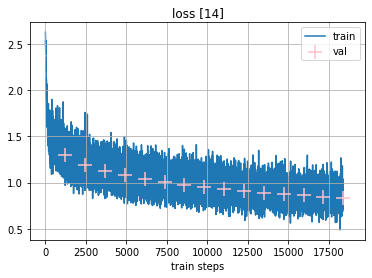

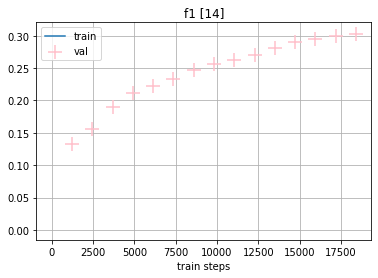

In [52]:
train(model, optimizer, criterion, BATCH_SIZE, 15)

In [53]:
save_checkpoint(model.state_dict(), 'checkpoint1.pth.tar')

## submit

In [69]:
submission = pd.read_csv(DATA_ROOT+'sample_submission.csv')
print(submission.shape)
submission.head()

(153730, 2)


,Id,Predicted
0,b005e5b2-2c0b-11e9-bcad-06f10d5896c4,0
1,f2347cfe-2c11-11e9-bcad-06f10d5896c4,0
2,27cf8d26-2c0e-11e9-bcad-06f10d5896c4,0
3,f82f52c7-2c1d-11e9-bcad-06f10d5896c4,0
4,e133f50d-2c1c-11e9-bcad-06f10d5896c4,0


In [129]:
test_df['category_id'] = submission['Predicted']
test_data = WildDataset(df=test_df, transforms=val_augmentation)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, 
                         shuffle=False, num_workers=12)

In [130]:
def test_epoch(model):
    model.eval()
    predict = []
    for i, (x_batch, _) in enumerate(test_loader):
        data = x_batch.to(DEVICE, dtype=torch.float)
        output = model(data)
        output = torch.argmax(output, dim=1)
        pred = output.data.cpu().numpy()
        predict.extend(pred)
    return predict  

In [131]:
test_df = test_df[['category_id', 'file_name']]

In [132]:
submission['Predicted'] = test_epoch(model)

error: Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/ubuntu/miniconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-72-5c19bebaf357>", line 13, in __getitem__
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.error: OpenCV(4.1.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



In [ ]:
submission['Predicted'] = submission['Predicted'].map(REVERSE_CLASSMAP)

In [ ]:
submission.to_csv('submission.csv', index=False)

In [121]:
for i, (x_batch, _) in enumerate(test_loader):
    print(i)

error: Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/ubuntu/miniconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-72-5c19bebaf357>", line 13, in __getitem__
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.error: OpenCV(4.1.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

